In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
Base.classes.keys()

['measurement', 'station']

In [5]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
session = Session(engine)

In [41]:
#Query for last 12 month precipitation data
last12m_data = session.query(Measurement.date, func.sum(Measurement.prcp).label("Total_Prcp")).filter(Measurement.date >= '2016-08-23').group_by(Measurement.date).statement
print(last12m_data)

SELECT measurement.date, sum(measurement.prcp) AS "Total_Prcp" 
FROM measurement 
WHERE measurement.date >= :date_1 GROUP BY measurement.date


In [42]:
prcp_df = pd.read_sql(last12m_data, engine, index_col='date')
prcp_df.head()

,Total_Prcp
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


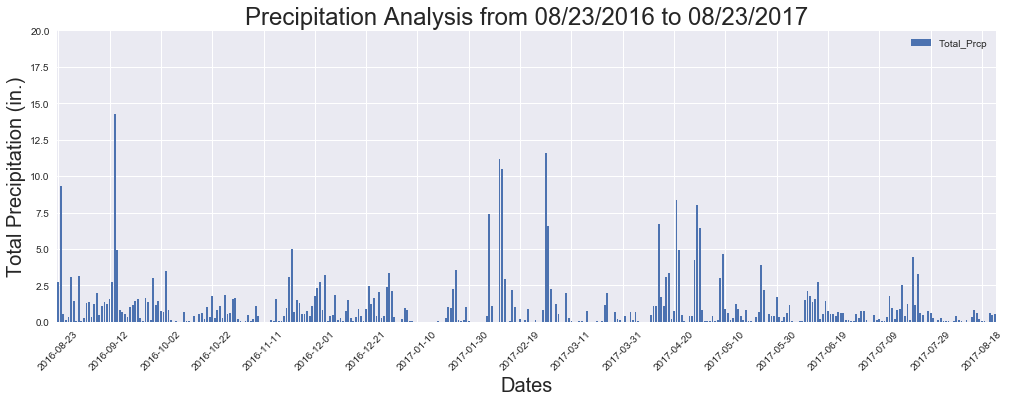

In [78]:
#Plot the Precipitation Analysis and showing only every 100 xtick
ax = prcp_df.plot.bar(rot = 45, ylim = (0,20), figsize=(15,5), width = 0.7)
n = 20
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])

plt.style.use('seaborn')
plt.xlabel("Dates", fontsize = 20)
plt.ylabel("Total Precipitation (in.)", fontsize= 20)
plt.title("Precipitation Analysis from 08/23/2016 to 08/23/2017", fontsize = 24)
plt.show()

In [49]:
prcp_df.describe()

,Total_Prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [50]:
session.query(func.count(Station.id)).all()

[(9)]

In [51]:
#Querying station id and respective observation count in descending order
stations_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).all()
print(stations_tobs)

[('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)]


In [52]:
print(f"The station with the highest observations is {stations_tobs[0][0]} with a total of {stations_tobs[0][1]} observations.")

The station with the highest observations is USC00519281 with a total of 2772 observations.


In [53]:
#Query for last 12 months of tobs data for the station with the highest observaton count
last12m_tobs = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= '2016-08-23')\
.filter(Measurement.station == 'USC00519281').statement
print(last12m_tobs)

SELECT measurement.station, measurement.tobs 
FROM measurement 
WHERE measurement.date >= :date_1 AND measurement.station = :station_1


In [54]:
tobs_df = pd.read_sql(last12m_tobs, engine)
tobs_df.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


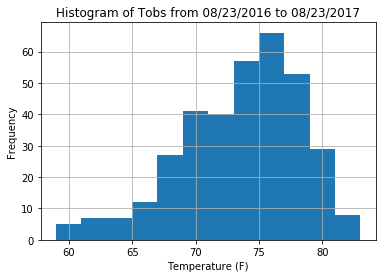

In [55]:
#Plot Tobs analysis in histogram with bin = 12
plt.hist(tobs_df['tobs'],bins = 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Histogram of Tobs from 08/23/2016 to 08/23/2017")
plt.grid()
plt.show()

In [275]:
measure_df = pd.read_sql('SELECT * FROM Measurement', engine)
measure_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-07,0.06,70.0


In [331]:
#Find the mean, max, and min temperature of a given time period and graph it
def calc_temp(start_date, end_date):
    query = (measure_df['date'] >= start_date) & (measure_df['date'] <= end_date)
    mean = round(measure_df[query]['tobs'].mean(),1)
    maxtobs = measure_df[query]['tobs'].max()
    mintobs = measure_df[query]['tobs'].min()
    
    fig, ax = plt.subplots(figsize = (4,7))
    plt.bar(x= [1], width = 1, height = mean, yerr = maxtobs-mintobs)    
    ax.set_xticks([0,1,2])
    plt.ylim(0,100)
    plt.tick_params(axis='x',which='both', labelbottom='off')
    plt.title('Trip Average Temperature', fontsize = 15)
    plt.ylabel("Temperature (F)", fontsize = 14)
    plt.show()
    print(f"The trip's average temperature is: {mean} degrees") 
    print(f"The trip's max temperature is: {maxtobs} degrees")
    print(f"The trip's minimum temperature is: {mintobs} degrees")

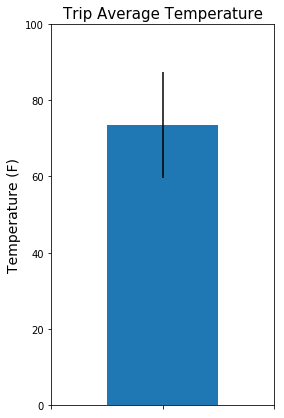

The trip's average temperature is: 73.5 degrees
The trip's max temperature is: 79.0 degrees
The trip's minimum temperature is: 65.0 degrees


In [332]:
calc_temp('2016-04-01', '2016-04-15')